---
### 📌 **BUSINESS PROBLEM UNDERSTANDING**
---

#### **Konteks**
Industri perhotelan sangat dipengaruhi oleh perilaku pemesanan customer atau tamu hotel. Perilaku ini dipengaruhi oleh beberapa faktor diantaranya faktor musiman (weekend, weekday, holiday), event (lokal & internasional), ekonomi, promosi serta diskon, dan lain sebagainya. Akibat ketidakpastian ini, pihak hotel harus memahami dan mengantisipasi perilaku customer yang berisiko merugikan hotel. Dalam hal ini, pembatalan reservasi yang berdampak pada operasional dan keuangan hotel. Tindakan antisipasi yang dapat dilakukan yakni memprediksi kemungkinan pembatalan reservasi oleh customer dengan memanfaatkan data historis pemesanan hotel sebelumnya.

**Dampak Pembatalan Reservasi terhadap Hotel**  
- Risiko kehilangan pendapatan (lost revenue) karena ketidakmampuan hotel melakukan tindakan cepat untuk mengisi kamar kosong dalam waktu singkat
- Mengganggu manajemen dan operasional hotel, khususnya dalam membuat strategi dan mengatur alokasi kamar  

---

#### **Solusi yang Ditawarkan: Machine Learning**

**Machine learning dapat membantu hotel memprediksi kemungkinan pembatalan reservasi secara lebih akurat,** berdasarkan pola data historis dan perilaku tamu.  
Dengan model prediksi pembatalan, hotel dapat:
- **Mengantisipasi risiko kerugian akibat pembatalan last-minute**
- **Membantu tim revenue management dan front office dalam pengambilan keputusan berbasis data**

Model ini dapat membantu **Revenue Manager, Front Office Manager, General Manager, serta tim operasional hotel** untuk mengambil keputusan operasional dan manajemen hotel. Prediksi ini dapat digunakan ketika proses reservasi masuk guna mencegah kerugian akibat pembatalan reservasi.

---

#### **Tujuan Project**

1. Membangun dan mengevaluasi model prediksi pembatalan reservasi hotel dengan **nilai Akurasi minimal 70% dan Recall kelas batal reservasi minimal 80%**.
2. **Memberikan rekomendasi keputusan bisnis** berdasarkan hasil prediksi model

---

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve


import pickle

---
### 📊 **DATA UNDERSTANDING**
---

In [65]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [66]:
info_df = pd.DataFrame({
    'Nama Kolom': df.columns,
    'Jumlah Data': df.count(),
    'Jumlah Missing': df.isnull().sum(),
    'Jumlah Data Unik': df.nunique(),
    'Tipe Data': df.dtypes  
}).reset_index(drop=True)

info_df.index += 1
info_df

,Nama Kolom,Jumlah Data,Jumlah Missing,Jumlah Data Unik,Tipe Data
1,country,83222,351,162,object
2,market_segment,83573,0,8,object
3,previous_cancellations,83573,0,15,int64
4,booking_changes,83573,0,19,int64
5,deposit_type,83573,0,3,object
6,days_in_waiting_list,83573,0,115,int64
7,customer_type,83573,0,4,object
8,reserved_room_type,83573,0,10,object
9,required_car_parking_spaces,83573,0,5,int64
10,total_of_special_requests,83573,0,6,int64


- **Jumlah Data     :** 83.573 data pemesanan kamar hotel 
- **Setiap kolom    :** Informasi yang relevan untuk memprediksi pembatalan reservasi

> #### **Distribusi Frekuensi Setiap Feature** 

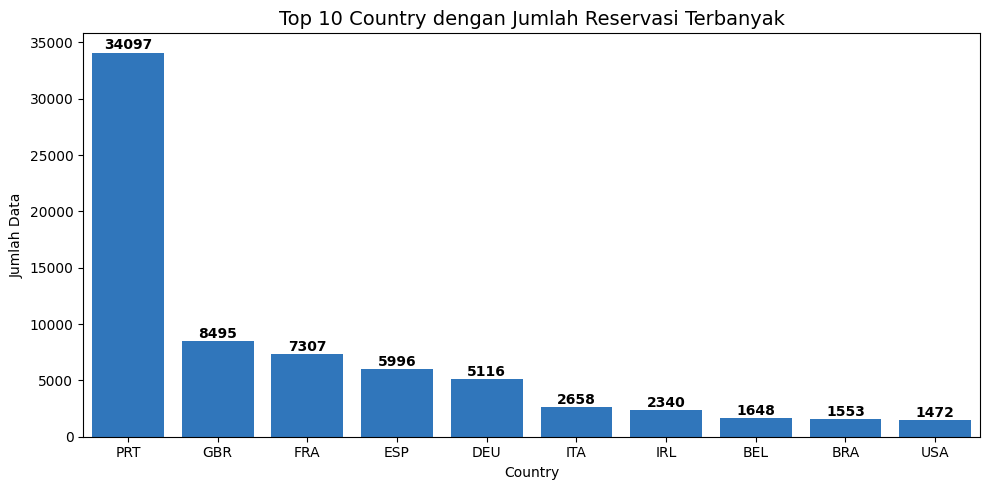

In [67]:
country_counts = df['country'].value_counts().head(10)

custom_colors = ['#1976D2'] 
plt.figure(figsize=(10, 5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette=custom_colors)

for i, val in enumerate(country_counts.values):
    plt.text(i, val + 10, str(val), ha='center', va='bottom', fontweight='bold')

plt.title('Top 10 Country dengan Jumlah Reservasi Terbanyak', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

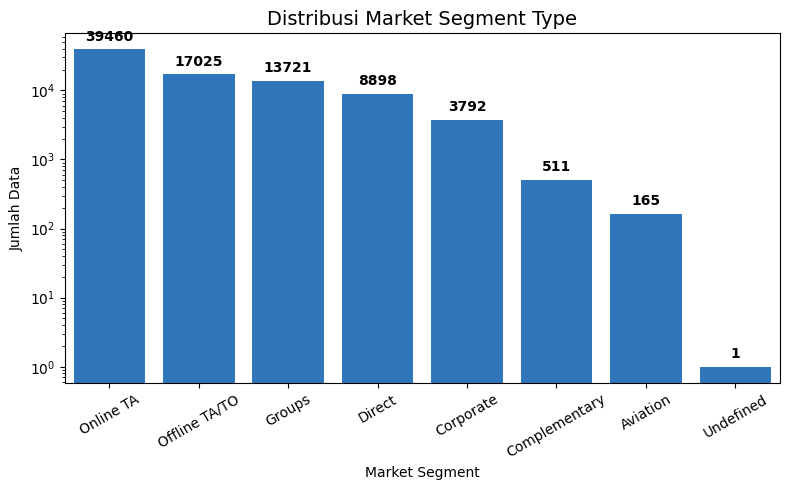

In [68]:
market_counts = df['market_segment'].value_counts()

custom_colors = ['#1976D2']
plt.figure(figsize=(8, 5))
sns.barplot(x=market_counts.index, y=market_counts.values, palette=custom_colors)

for i, val in enumerate(market_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.title('Distribusi Market Segment Type', fontsize=14)
plt.xlabel('Market Segment')
plt.ylabel('Jumlah Data')
plt.yscale('log')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

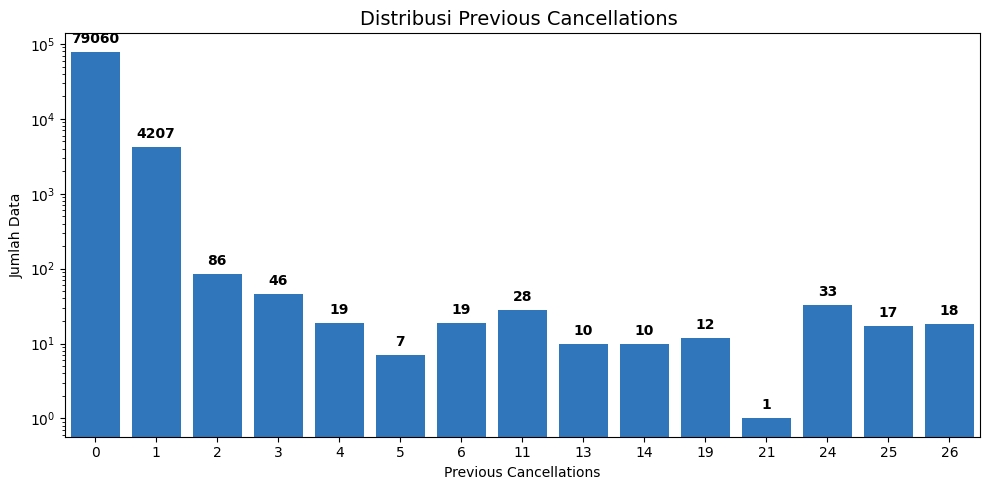

In [69]:
prev_cancel_counts = df['previous_cancellations'].value_counts().sort_index()

custom_colors = ['#1976D2']
plt.figure(figsize=(10, 5))
sns.barplot(x=prev_cancel_counts.index, y=prev_cancel_counts.values, palette=custom_colors)

for i, val in enumerate(prev_cancel_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Previous Cancellations ', fontsize=14)
plt.xlabel('Previous Cancellations')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()


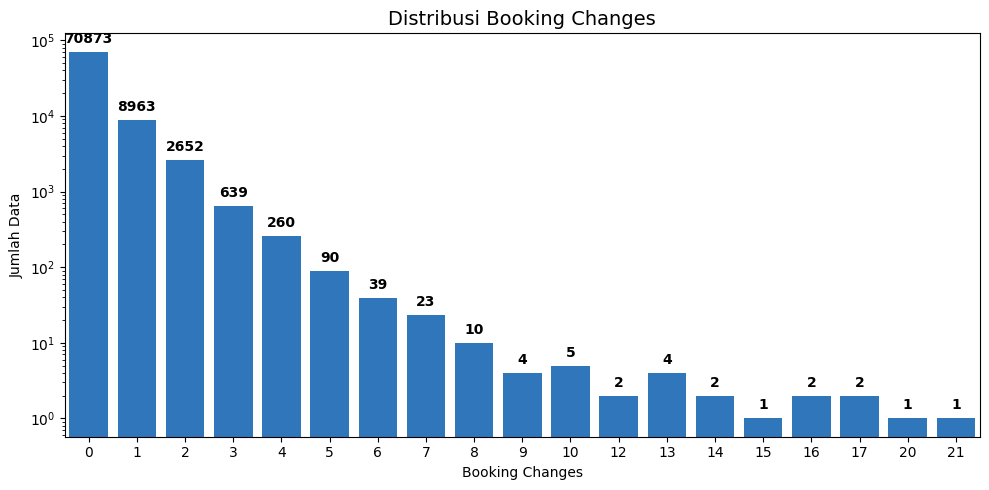

In [70]:
booking_changes_counts = df['booking_changes'].value_counts().sort_index()

custom_colors = ['#1976D2']
plt.figure(figsize=(10, 5))
sns.barplot(x=booking_changes_counts.index, y=booking_changes_counts.values, palette=custom_colors)

for i, val in enumerate(booking_changes_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Booking Changes', fontsize=14)
plt.xlabel('Booking Changes')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

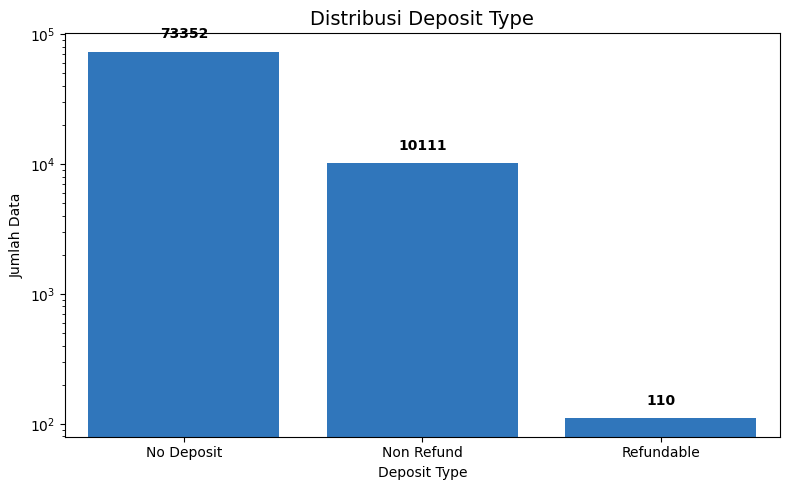

In [71]:
deposit_counts = df['deposit_type'].value_counts()

custom_colors = ['#1976D2']
plt.figure(figsize=(8, 5))
sns.barplot(x=deposit_counts.index, y=deposit_counts.values, palette=custom_colors)

for i, val in enumerate(deposit_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Deposit Type', fontsize=14)
plt.xlabel('Deposit Type')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

In [72]:
days_in_waiting_list_count = df['days_in_waiting_list'].value_counts().reset_index()
days_in_waiting_list_count.columns = ['Days in Waiting List', 'Count']

days_in_waiting_list_count

,Days in Waiting List,Count
0,0,80988
1,39,166
2,58,104
3,44,93
4,31,93
...,...,...
110,74,1
111,121,1
112,36,1
113,64,1


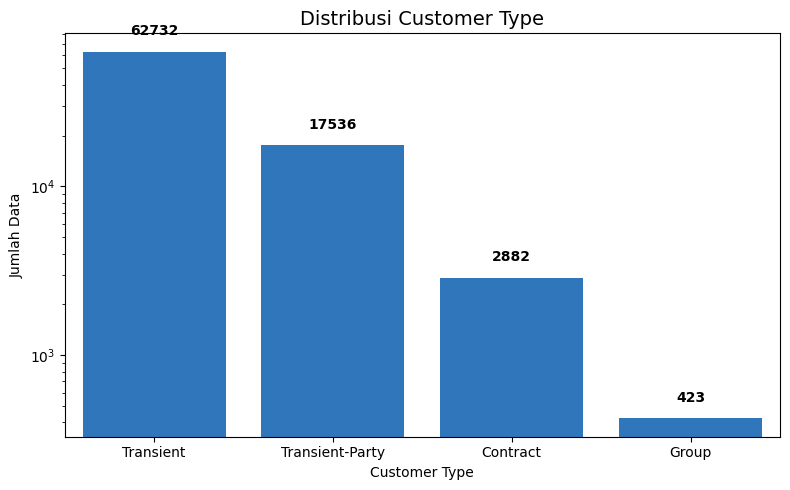

In [73]:
customer_counts = df['customer_type'].value_counts()

custom_colors = ['#1976D2']
plt.figure(figsize=(8, 5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, palette=custom_colors)

for i, val in enumerate(customer_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Customer Type', fontsize=14)
plt.xlabel('Customer Type')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

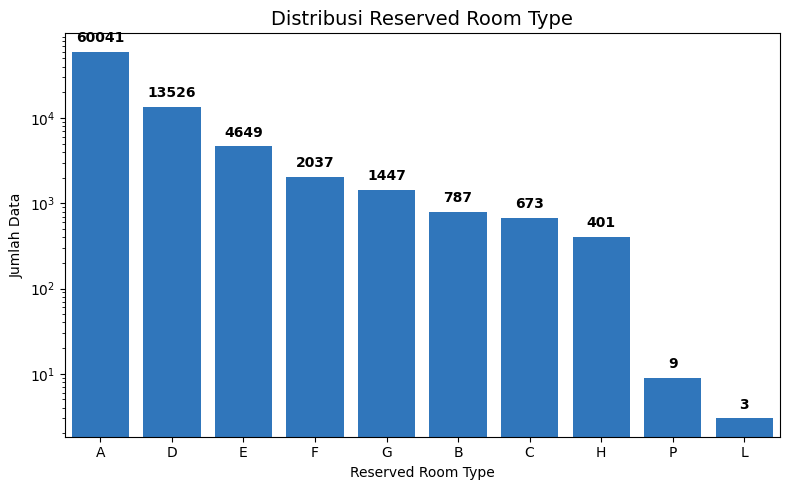

In [74]:
room_counts = df['reserved_room_type'].value_counts()

custom_colors = ['#1976D2']
plt.figure(figsize=(8, 5))
sns.barplot(x=room_counts.index, y=room_counts.values, palette=custom_colors)

for i, val in enumerate(room_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Reserved Room Type', fontsize=14)
plt.xlabel('Reserved Room Type')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

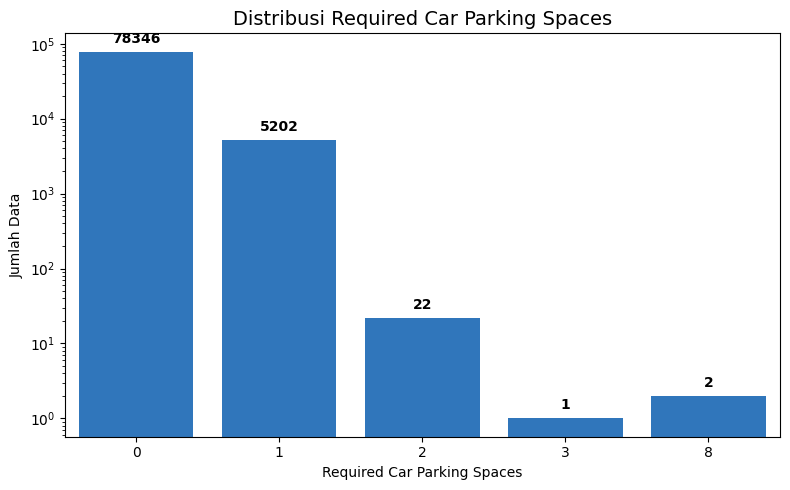

In [75]:
parking_counts = df['required_car_parking_spaces'].value_counts().sort_index()

custom_colors = ['#1976D2']
plt.figure(figsize=(8, 5))
sns.barplot(x=parking_counts.index.astype(str), y=parking_counts.values, palette=custom_colors)

for i, val in enumerate(parking_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Required Car Parking Spaces', fontsize=14)
plt.xlabel('Required Car Parking Spaces')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

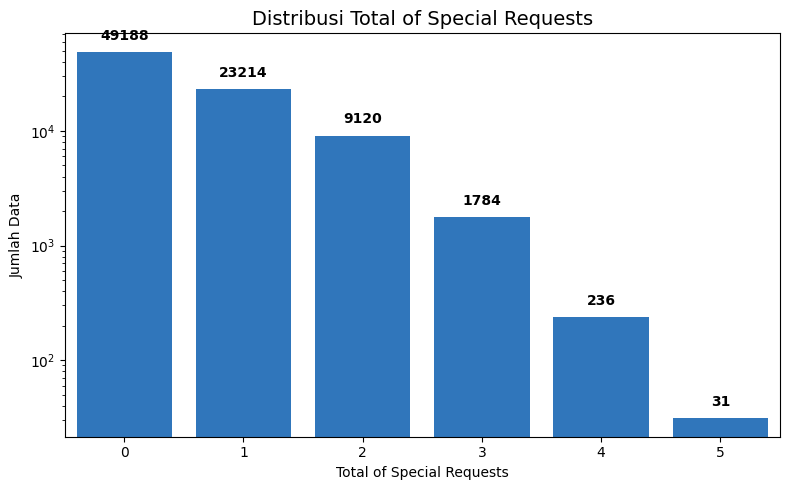

In [76]:
special_req_counts = df['total_of_special_requests'].value_counts().sort_index()

custom_colors = ['#1976D2']
plt.figure(figsize=(8, 5))
sns.barplot(x=special_req_counts.index.astype(str), y=special_req_counts.values, palette=custom_colors)

for i, val in enumerate(special_req_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Total of Special Requests', fontsize=14)
plt.xlabel('Total of Special Requests')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

> #### **Target "is_canceled"**
Tujuan analisis dilakukan untuk memprediksi dan meminimalisir pembatalan pemesanan sehingga fokus pada informasi di kolom "is canceled"

| Nama Kolom    | Tipe Data | Deskripsi                                              | Kaitannya dengan Bisnis                                                                                                                                                                            |
| ------------- | --------- | ------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `is_canceled` | int64     | Status pembatalan (1: dibatalkan, 0: tidak dibatalkan) | **Target prediksi utama dalam project ini** <br> Untuk mengukur tingkat pembatalan reservasi, memahami pola pembatalan, dan menjadi dasar pengambilan keputusan untuk strategi bisnis hotel |

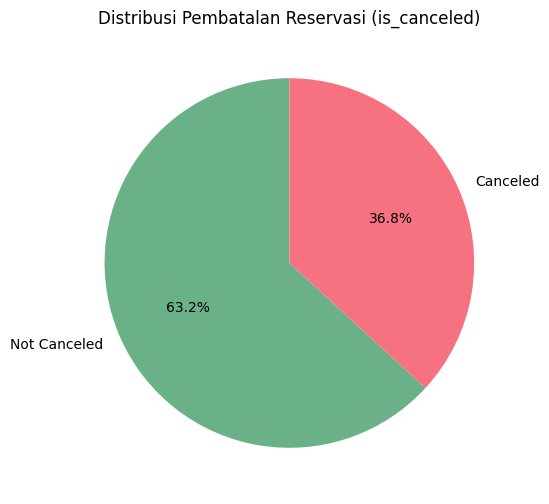

In [77]:
plt.figure(figsize=(6, 6))
df['is_canceled'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['Not Canceled', 'Canceled'],
    startangle=90,
    colors=['#6ab187', '#f67280']
)
plt.title('Distribusi Pembatalan Reservasi (is_canceled)')
plt.ylabel('')
plt.show()

---
### 🔄 **DATA PREPROCCESING**
---

> #### **Cleaning**

In [78]:
# Imputasi Missing Value pada Feature Country

df['country'] = df['country'].fillna('Other')
df.isnull().sum()

country_count = df['country'].value_counts().reset_index()
country_count.columns = ['Country', 'Count']

country_count

,Country,Count
0,PRT,34097
1,GBR,8495
2,FRA,7307
3,ESP,5996
4,DEU,5116
...,...,...
158,DMA,1
159,KIR,1
160,MYT,1
161,KNA,1


In [79]:
dupes = df.duplicated()
print("Jumlah baris duplikat:", dupes.sum())

Jumlah baris duplikat: 73371


Dataset ini duplikatnya ekstrim ==> dari 83.573 baris , **88%** (73.371) **data sama persis**

Tidak dapat dipastikan apakah data duplikat ini adalah kondisi sebenarnya atau error input karena tidak ada keterangan lebih lanjut mengenai dataset.
Data duplikat ini berisiko membuat model overfitting dan bias sehingga lebih baik datanya di drop. 

In [80]:
# Menghapus Data Duplikat

df.drop_duplicates(inplace=True)
df.duplicated().sum()
print("Jumlah Data :", df.shape)

Jumlah Data : (10202, 11)


Setelah data di drop, dari 83.573 baris tersisa 10.202 baris

> #### **FEATURE SELECTION & FEATURE ENGINEERING**

In [81]:
# Mengkategorikan Feature Country menjadi 3 Jenis

def group_country(x):
    if x == 'PRT':
        return 'Portugal'
    elif x == 'Other':
        return 'Other'
    else:
        return 'Non Portugal'
df['country_grouped'] = df['country'].apply(group_country)

In [82]:
# Menyiapkan Feature yang akan dilakukan Encode

categorical_cols = ['country_grouped', 'market_segment', 'deposit_type', 'customer_type']
ordinal_col = ['reserved_room_type']
numerical_cols = [
    'previous_cancellations',
    'booking_changes',
    'days_in_waiting_list',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

In [83]:
# Encode Feature: Pipeline Preprocessing FS & FE 
# Feature Categorical   => OneHot Encoder
# Feature Ordinal       => Ordinal Encoder
# Feature Numerical     => Robust Scaler

room_order = [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L','P']]

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(sparse_output=False), categorical_cols),
    ('ord', OrdinalEncoder(categories=room_order), ordinal_col),
    ('num', RobustScaler(), numerical_cols)
])

X_features = categorical_cols + ordinal_col + numerical_cols
processed_array = preprocessor.fit_transform(df[X_features])

In [84]:
# Hasil Encoding Menghasilkan Total 24 Feature (tanpa target) 

onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([
    onehot_feature_names,
    ['reserved_room_type_ordinal'],
    numerical_cols
])
 

df_final = pd.DataFrame(processed_array, columns=all_feature_names, index=df.index)

df_final['is_canceled'] = df['is_canceled'].values

df_final.columns = df_final.columns.str.replace(' ', '_')

df_final.columns

Index(['country_grouped_Non_Portugal', 'country_grouped_Other',
       'country_grouped_Portugal', 'market_segment_Aviation',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline_TA/TO', 'market_segment_Online_TA',
       'market_segment_Undefined', 'deposit_type_No_Deposit',
       'deposit_type_Non_Refund', 'deposit_type_Refundable',
       'customer_type_Contract', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'reserved_room_type_ordinal', 'previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests',
       'is_canceled'],
      dtype='object')

---
### 🤖 **Modeling**
---

> #### **ANALYTICS (ALGORITHM & EVALUATION METRICS)** 

In [85]:
X = df_final.drop(columns='is_canceled')
y = df_final['is_canceled']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Proporsi target di train:", y_train.value_counts(normalize=True))
print("Proporsi target di test :", y_test.value_counts(normalize=True))


Train shape: (7141, 24) Test shape: (3061, 24)
Proporsi target di train: is_canceled
0    0.763338
1    0.236662
Name: proportion, dtype: float64
Proporsi target di test : is_canceled
0    0.763476
1    0.236524
Name: proportion, dtype: float64


Dalam menemukan model yang paling baik, Recall menjadi fokus utama pemilihan model. Hal ini sejalan dengan tujuan awal yakni untuk mendapatkan model yang bisa memprediksi customer/tamu hotel yang mungkin akan membatalkan reservasinya. Khususnya pada tamu yang terlihat akan datang namun nyatanya membatalkan reservasinya (False Negative). Kasus FN ini paling berisiko tinggi pada operasional dan manajemen hotel sehingga pengendalian FN ini menjadi fokus utama prediksi. 

Semakin tinggi recall, semakin sedikit FN yang lolos dari deteksi model. Oleh karena itu, model dievaluasi dan dipilih berdasarkan performanya dalam meminimalkan FN melalui peningkatan recall, meskipun mungkin harus mengorbankan sedikit nilai precision atau accuracy secara keseluruhan.

> #### **MODEL - LOGISTIC REGRESSION**

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2337
           1       0.61      0.31      0.41       724

    accuracy                           0.79      3061
   macro avg       0.71      0.62      0.64      3061
weighted avg       0.76      0.79      0.76      3061

Confusion Matrix:
 [[2193  144]
 [ 503  221]]


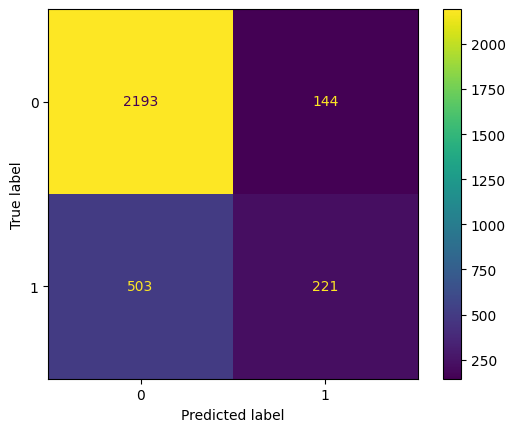

In [87]:
# Train logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1] 

# Evaluasi hasil
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

> #### **MODEL – KNN**

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      2337
           1       0.48      0.37      0.42       724

    accuracy                           0.75      3061
   macro avg       0.65      0.62      0.63      3061
weighted avg       0.74      0.75      0.74      3061

Confusion Matrix (KNN):
 [[2039  298]
 [ 453  271]]


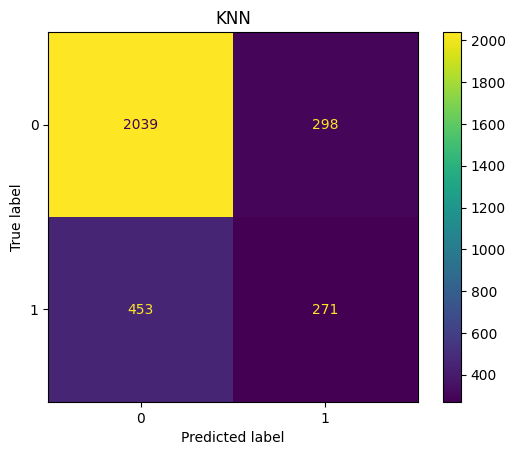

In [88]:
# Train KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.title("KNN")
plt.show()

> #### **MODEL – DECISION TREE**

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2337
           1       0.48      0.36      0.42       724

    accuracy                           0.76      3061
   macro avg       0.65      0.62      0.63      3061
weighted avg       0.74      0.76      0.75      3061

Confusion Matrix (Decision Tree):
 [[2055  282]
 [ 460  264]]


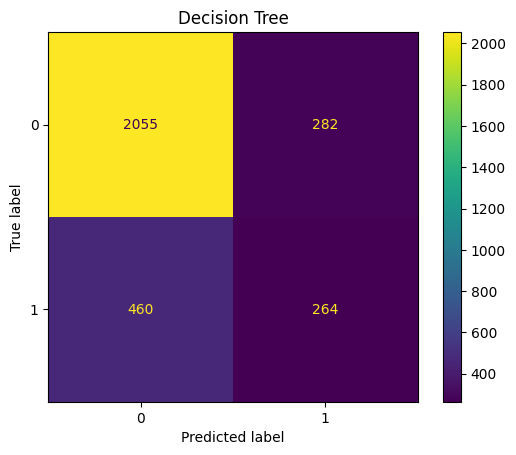

In [89]:
# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix (Decision Tree):\n", confusion_matrix(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Decision Tree")
plt.show()

> #### **MODEL – RANDOM FOREST**

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2337
           1       0.49      0.37      0.42       724

    accuracy                           0.76      3061
   macro avg       0.66      0.63      0.64      3061
weighted avg       0.74      0.76      0.75      3061

Confusion Matrix (Random Forest):
 [[2066  271]
 [ 459  265]]


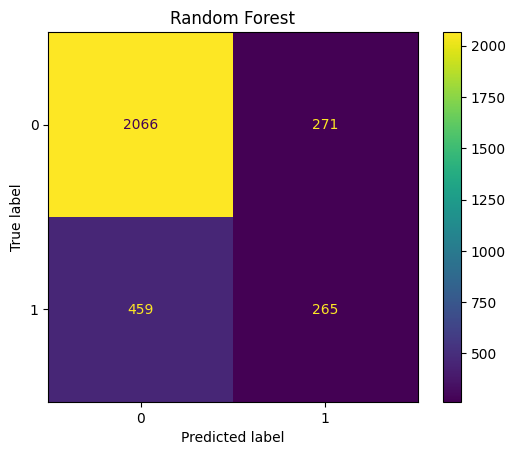

In [90]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest")
plt.show()

> #### **MODEL – XGBoost**

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      2337
           1       0.59      0.35      0.43       724

    accuracy                           0.79      3061
   macro avg       0.70      0.63      0.65      3061
weighted avg       0.76      0.79      0.77      3061

Confusion Matrix (XGBoost):
 [[2161  176]
 [ 474  250]]


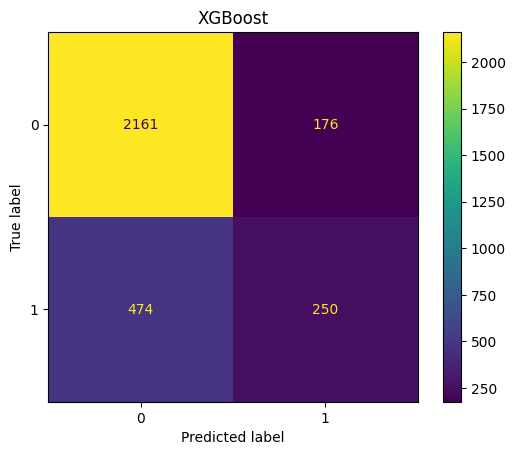

In [91]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost")
plt.show()

> #### **Tuning Semua Model**

Tuning threshold dilakukan untuk mengevaluasi bagaimana performa model berubah saat ambang prediksi digeser. Oleh karena fokus utama adalah meminimalkan kesalahan False Negative (FN), maka recall terhadap kelas 1 menjadi prioritas utama. Dengan menyesuaikan threshold, model dapat menjadi lebih sensitif terhadap kasus pembatalan pemesanan (kelas 1) sehingga meningkatkan deteksi dini terhadap potensi pembatalan, yang sangat krusial bagi pengelolaan kapasitas hotel.

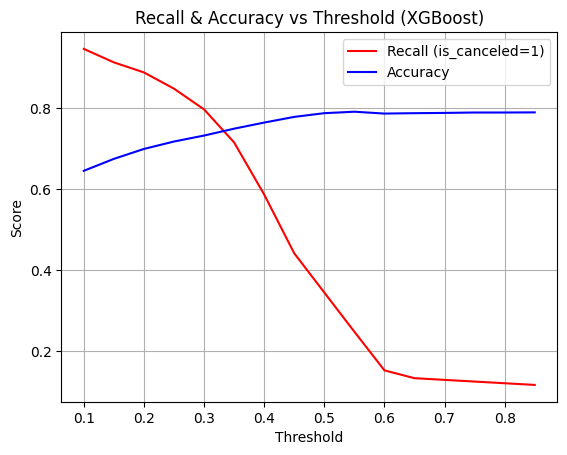

XGBoost | Threshold: 0.10 | Recall: 0.946 | Accuracy: 0.646
XGBoost | Threshold: 0.15 | Recall: 0.913 | Accuracy: 0.675
XGBoost | Threshold: 0.20 | Recall: 0.888 | Accuracy: 0.699
XGBoost | Threshold: 0.25 | Recall: 0.848 | Accuracy: 0.718
XGBoost | Threshold: 0.30 | Recall: 0.797 | Accuracy: 0.732
XGBoost | Threshold: 0.35 | Recall: 0.715 | Accuracy: 0.749
XGBoost | Threshold: 0.40 | Recall: 0.587 | Accuracy: 0.764
XGBoost | Threshold: 0.45 | Recall: 0.442 | Accuracy: 0.779
XGBoost | Threshold: 0.50 | Recall: 0.345 | Accuracy: 0.788
XGBoost | Threshold: 0.55 | Recall: 0.249 | Accuracy: 0.791
XGBoost | Threshold: 0.60 | Recall: 0.153 | Accuracy: 0.787
XGBoost | Threshold: 0.65 | Recall: 0.134 | Accuracy: 0.788
XGBoost | Threshold: 0.70 | Recall: 0.130 | Accuracy: 0.788
XGBoost | Threshold: 0.75 | Recall: 0.126 | Accuracy: 0.789
XGBoost | Threshold: 0.80 | Recall: 0.122 | Accuracy: 0.789
XGBoost | Threshold: 0.85 | Recall: 0.117 | Accuracy: 0.790


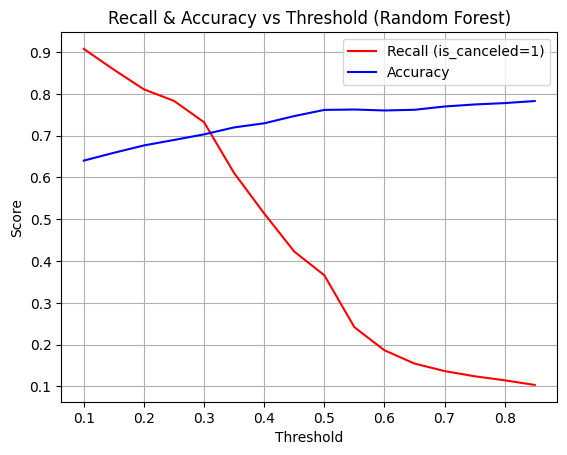

Random Forest | Threshold: 0.10 | Recall: 0.907 | Accuracy: 0.640
Random Forest | Threshold: 0.15 | Recall: 0.858 | Accuracy: 0.659
Random Forest | Threshold: 0.20 | Recall: 0.811 | Accuracy: 0.677
Random Forest | Threshold: 0.25 | Recall: 0.783 | Accuracy: 0.690
Random Forest | Threshold: 0.30 | Recall: 0.732 | Accuracy: 0.703
Random Forest | Threshold: 0.35 | Recall: 0.610 | Accuracy: 0.720
Random Forest | Threshold: 0.40 | Recall: 0.514 | Accuracy: 0.730
Random Forest | Threshold: 0.45 | Recall: 0.423 | Accuracy: 0.747
Random Forest | Threshold: 0.50 | Recall: 0.366 | Accuracy: 0.762
Random Forest | Threshold: 0.55 | Recall: 0.242 | Accuracy: 0.762
Random Forest | Threshold: 0.60 | Recall: 0.186 | Accuracy: 0.760
Random Forest | Threshold: 0.65 | Recall: 0.155 | Accuracy: 0.762
Random Forest | Threshold: 0.70 | Recall: 0.137 | Accuracy: 0.770
Random Forest | Threshold: 0.75 | Recall: 0.124 | Accuracy: 0.775
Random Forest | Threshold: 0.80 | Recall: 0.115 | Accuracy: 0.778
Random For

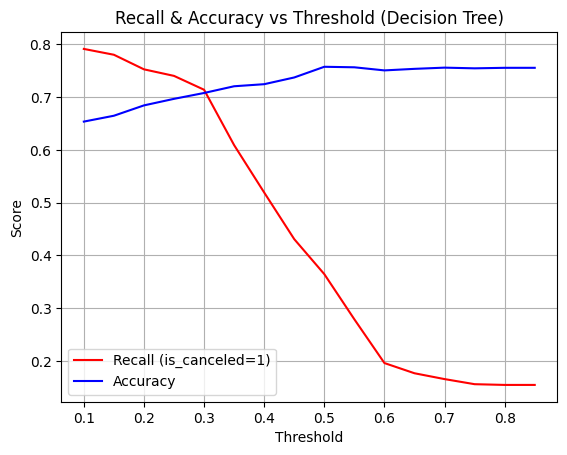

Decision Tree | Threshold: 0.10 | Recall: 0.791 | Accuracy: 0.654
Decision Tree | Threshold: 0.15 | Recall: 0.780 | Accuracy: 0.665
Decision Tree | Threshold: 0.20 | Recall: 0.753 | Accuracy: 0.684
Decision Tree | Threshold: 0.25 | Recall: 0.740 | Accuracy: 0.697
Decision Tree | Threshold: 0.30 | Recall: 0.714 | Accuracy: 0.708
Decision Tree | Threshold: 0.35 | Recall: 0.609 | Accuracy: 0.721
Decision Tree | Threshold: 0.40 | Recall: 0.519 | Accuracy: 0.725
Decision Tree | Threshold: 0.45 | Recall: 0.431 | Accuracy: 0.737
Decision Tree | Threshold: 0.50 | Recall: 0.365 | Accuracy: 0.758
Decision Tree | Threshold: 0.55 | Recall: 0.279 | Accuracy: 0.757
Decision Tree | Threshold: 0.60 | Recall: 0.196 | Accuracy: 0.751
Decision Tree | Threshold: 0.65 | Recall: 0.177 | Accuracy: 0.754
Decision Tree | Threshold: 0.70 | Recall: 0.166 | Accuracy: 0.756
Decision Tree | Threshold: 0.75 | Recall: 0.156 | Accuracy: 0.755
Decision Tree | Threshold: 0.80 | Recall: 0.155 | Accuracy: 0.756
Decision T

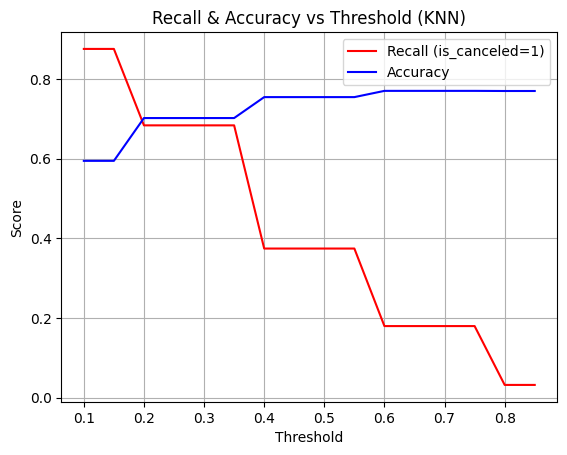

KNN | Threshold: 0.10 | Recall: 0.876 | Accuracy: 0.595
KNN | Threshold: 0.15 | Recall: 0.876 | Accuracy: 0.595
KNN | Threshold: 0.20 | Recall: 0.684 | Accuracy: 0.702
KNN | Threshold: 0.25 | Recall: 0.684 | Accuracy: 0.702
KNN | Threshold: 0.30 | Recall: 0.684 | Accuracy: 0.702
KNN | Threshold: 0.35 | Recall: 0.684 | Accuracy: 0.702
KNN | Threshold: 0.40 | Recall: 0.374 | Accuracy: 0.755
KNN | Threshold: 0.45 | Recall: 0.374 | Accuracy: 0.755
KNN | Threshold: 0.50 | Recall: 0.374 | Accuracy: 0.755
KNN | Threshold: 0.55 | Recall: 0.374 | Accuracy: 0.755
KNN | Threshold: 0.60 | Recall: 0.180 | Accuracy: 0.770
KNN | Threshold: 0.65 | Recall: 0.180 | Accuracy: 0.770
KNN | Threshold: 0.70 | Recall: 0.180 | Accuracy: 0.770
KNN | Threshold: 0.75 | Recall: 0.180 | Accuracy: 0.770
KNN | Threshold: 0.80 | Recall: 0.032 | Accuracy: 0.770
KNN | Threshold: 0.85 | Recall: 0.032 | Accuracy: 0.770


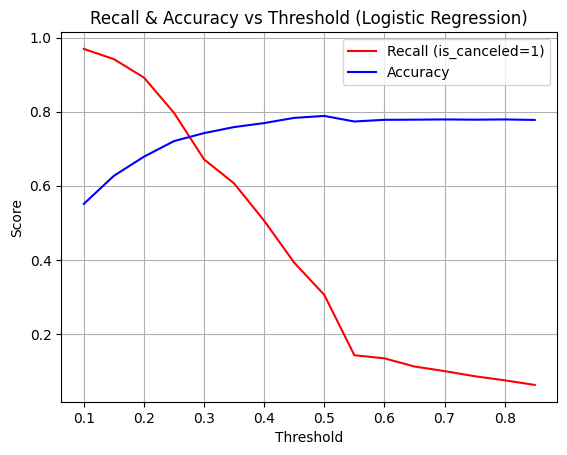

Logistic Regression | Threshold: 0.10 | Recall: 0.970 | Accuracy: 0.551
Logistic Regression | Threshold: 0.15 | Recall: 0.942 | Accuracy: 0.627
Logistic Regression | Threshold: 0.20 | Recall: 0.892 | Accuracy: 0.679
Logistic Regression | Threshold: 0.25 | Recall: 0.797 | Accuracy: 0.721
Logistic Regression | Threshold: 0.30 | Recall: 0.671 | Accuracy: 0.742
Logistic Regression | Threshold: 0.35 | Recall: 0.606 | Accuracy: 0.759
Logistic Regression | Threshold: 0.40 | Recall: 0.506 | Accuracy: 0.769
Logistic Regression | Threshold: 0.45 | Recall: 0.392 | Accuracy: 0.783
Logistic Regression | Threshold: 0.50 | Recall: 0.305 | Accuracy: 0.789
Logistic Regression | Threshold: 0.55 | Recall: 0.142 | Accuracy: 0.774
Logistic Regression | Threshold: 0.60 | Recall: 0.134 | Accuracy: 0.778
Logistic Regression | Threshold: 0.65 | Recall: 0.112 | Accuracy: 0.779
Logistic Regression | Threshold: 0.70 | Recall: 0.099 | Accuracy: 0.779
Logistic Regression | Threshold: 0.75 | Recall: 0.086 | Accuracy

In [92]:
def threshold_tuning(y_test, y_proba, model_name):
    thresholds = np.arange(0.1, 0.9, 0.05)
    recalls = []
    accuracies = []

    for t in thresholds:
        preds = (y_proba > t).astype(int)
        recalls.append(recall_score(y_test, preds))
        accuracies.append(accuracy_score(y_test, preds))

    plt.plot(thresholds, recalls, label="Recall (is_canceled=1)", color='red')
    plt.plot(thresholds, accuracies, label="Accuracy", color='blue')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Recall & Accuracy vs Threshold ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    for i, t in enumerate(thresholds):
        print(f"{model_name} | Threshold: {t:.2f} | Recall: {recalls[i]:.3f} | Accuracy: {accuracies[i]:.3f}")

# --- Jalankan untuk setiap model ---
threshold_tuning(y_test, y_proba_xgb, "XGBoost")
threshold_tuning(y_test, y_proba_rf, "Random Forest")
threshold_tuning(y_test, y_proba_dt, "Decision Tree")
threshold_tuning(y_test, y_proba_knn, "KNN")
threshold_tuning(y_test, y_proba, "Logistic Regression")

**Tabel Perbandingan Hasil Modeling**

| Model               | Threshold | Recall (1) | Accuracy |
| ------------------- | --------- | ---------- | -------- |
| XGBoost             | 0.30      | 0.797      | 0.732    |
| Random Forest       | 0.30      | 0.732      | 0.703    |
| Decision Tree       | 0.30      | 0.714      | 0.708    |
| KNN                 | 0.20–0.35 | 0.684      | 0.702    |
| Logistic Regression | 0.30      | 0.671      | 0.742    |

Note:
Alternatif Threshold: Recall Tetap Tinggi, Accuracy di Atas 0.70

In [93]:
best_thr = 0.30
final_pred_xgb = (y_proba_xgb > best_thr).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("XGBoost @ threshold 0.30:")
print(classification_report(y_test, final_pred_xgb))
print(confusion_matrix(y_test, final_pred_xgb))

XGBoost @ threshold 0.30:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      2337
           1       0.46      0.80      0.58       724

    accuracy                           0.73      3061
   macro avg       0.69      0.75      0.69      3061
weighted avg       0.81      0.73      0.75      3061

[[1665  672]
 [ 147  577]]


Interpretasi

Recall tinggi (0.80) untuk pembatalan:
80% booking yang memang akan dibatalkan berhasil dideteksi model (sesuai tujuan utama).

Accuracy tetap terjaga (0.73):
Masih sangat baik untuk dataset imbalanced.

Precision kelas 1 cukup rendah (0.46):
Banyak “booking tidak batal” yang diprediksi “batal” (false positive naik),
tapi ini adalah trade-off yang wajar jika recall lebih diprioritaskan.

lakukan balancing dengan smote

In [94]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Oversample
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", y_train.value_counts())
print("Setelah SMOTE:", pd.Series(y_train_sm).value_counts())

# Train ulang XGBoost dengan data oversampling
xgb_sm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_sm.fit(X_train_sm, y_train_sm)

# Predict proba di test set asli
y_proba_xgb_sm = xgb_sm.predict_proba(X_test)[:, 1]

# Ulangi threshold tuning (ambil misal 0.25, 0.30, dst.)
for t in [0.25, 0.30, 0.35, 0.40]:
    y_pred = (y_proba_xgb_sm > t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


Sebelum SMOTE: is_canceled
0    5451
1    1690
Name: count, dtype: int64
Setelah SMOTE: is_canceled
0    5451
1    5451
Name: count, dtype: int64

Threshold: 0.25
              precision    recall  f1-score   support

           0       0.95      0.61      0.75      2337
           1       0.42      0.89      0.57       724

    accuracy                           0.68      3061
   macro avg       0.68      0.75      0.66      3061
weighted avg       0.82      0.68      0.70      3061

[[1436  901]
 [  78  646]]

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      2337
           1       0.43      0.86      0.57       724

    accuracy                           0.69      3061
   macro avg       0.68      0.75      0.67      3061
weighted avg       0.82      0.69      0.72      3061

[[1499  838]
 [ 102  622]]

Threshold: 0.35
              precision    recall  f1-score   support

           0       0.93      0.67      0.

terbaik dapat di 0.37

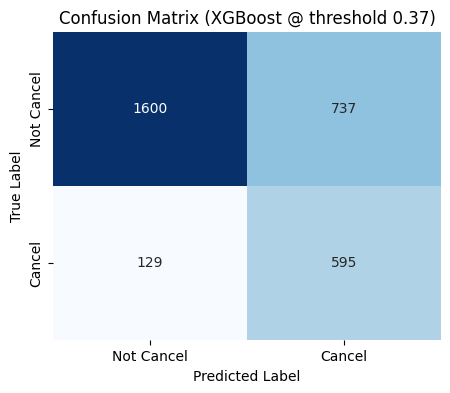

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      2337
           1       0.45      0.82      0.58       724

    accuracy                           0.72      3061
   macro avg       0.69      0.75      0.68      3061
weighted avg       0.81      0.72      0.74      3061



In [95]:
best_thr = 0.37
final_pred_xgb_best = (y_proba_xgb_sm > best_thr).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
# Hitung confusion matrix
cm = confusion_matrix(y_test, final_pred_xgb_best)

# Buat plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Cancel', 'Cancel'],
            yticklabels=['Not Cancel', 'Cancel'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (XGBoost @ threshold {best_thr})')
plt.show()
print(classification_report(y_test, final_pred_xgb_best))


Pada kasus prediksi pembatalan reservasi hotel, recall untuk kelas canceled (is_canceled=1) menjadi metrik utama. Ini karena hotel sangat ingin meminimalisir kehilangan reservasi yang benar-benar batal (mencegah missed cancellation).

- Recall (1) 0.82: Model mampu menangkap 80% dari semua reservasi yang memang benar-benar dibatalkan.

- Precision (1) 0.45: Dari semua reservasi yang diprediksi akan batal oleh model, 45% benar-benar batal (masih ada false positive, tapi bisa ditangani dengan proses bisnis seperti reminder/konfirmasi ke customer).

- Accuracy 0.72: Model secara umum benar 72% dari seluruh prediksi (cukup baik mengingat imbalance dataset).

Kaitan ke Bisnis

- Recall tinggi mengurangi risiko missed cancellation—hotel bisa lebih siap melakukan tindakan preventif (misal, konfirmasi ulang atau penalty ke customer).

- Precision sedang artinya ada beberapa booking yang sebenarnya tidak cancel tapi diprediksi cancel (false positive)—bisa digunakan sebagai alert untuk customer service, bukan langsung penalty.



(Trust Level) Model sangat baik digunakan saat:

- Hotel ingin mengantisipasi kerugian akibat last-minute cancellation.

- Recall prioritas: Model dapat dipercaya untuk early warning (menandai reservasi berisiko tinggi).

>Tampilkan 10 fitur terpenting dari XGBoost.

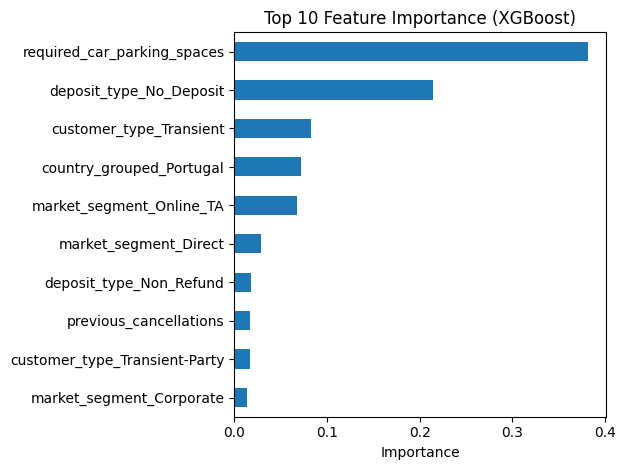

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importance = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importance.sort_values(ascending=False).head(10).plot(kind='barh')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


2 fitur importance paling berpengaruh

1. required_car_parking_spaces
- Pentingnya: Fitur ini memiliki pengaruh paling besar terhadap prediksi model.
- Interpretasi: Jumlah kebutuhan tempat parkir sangat berkorelasi dengan perilaku target (kemungkinan besar pembatalan reservasi atau outcome lain yang kamu prediksi).
- Implikasi: Mungkin tamu yang membutuhkan banyak tempat parkir memiliki karakteristik reservasi yang berbeda, misal: rombongan, acara khusus, atau kebutuhan tinggi lainnya, sehingga berdampak pada probabilitas outcome.

2. deposit_type_No_Deposit
- Pentingnya: Sangat signifikan, berada di urutan kedua.
- Interpretasi: Jenis deposit “No Deposit” menjadi indikator kuat. Biasanya, pemesanan tanpa deposit lebih mudah dibatalkan, atau cenderung tidak sekomitmen reservasi dengan deposit.

### 🎯 Simulasi Perhitungan Untung-Rugi Model Prediksi Pembatalan Hotel

---

#### **Tanpa Machine Learning (Prediksi Manual)**

**Asumsi Dasar:**
- Harga sewa kamar hotel per malam: **Rp1.500.000**
- Jumlah booking masuk: **200 reservasi**

---

##### **Situasi Tanpa Model Prediksi**
Hotel tidak bisa tahu mana yang akan batal atau tidak.  
Jika ada yang **batal mendadak**, kamar kosong = rugi.  
Jika hotel nekat **overbooking** dan semua tamu datang = hotel rugi (harus kasih kompensasi).

---

**Contoh Kondisi 1 (Tanpa Model):**
- Prediksi: 100 batal, 100 tidak batal.
- Kenyataan: **Semua tamu datang** (tidak ada yang batal).

| Keterangan                       | Jumlah Kamar | Untung/Rugi per Kamar | Total           |
|-----------------------------------|--------------|-----------------------|-----------------|
| Kamar laku (benar-benar datang)   | 100          | **+Rp1.500.000**      | Rp150.000.000   |
| Overbook (harus kompensasi)       | 100          | **-Rp1.125.000**      | -Rp112.500.000  |
| **Total**                         |              |                       | **Rp37.500.000**|

---

**Contoh Kondisi Paling Ideal (Tanpa Model):**
- Prediksi: 100 batal, 100 tidak batal.
- Kenyataan: **Benar-benar ada 100 batal, 100 tidak batal**.

| Keterangan                       | Jumlah Kamar | Untung/Rugi per Kamar | Total           |
|-----------------------------------|--------------|-----------------------|-----------------|
| Kamar laku ke tamu asli           | 100          | **+Rp1.500.000**      | Rp150.000.000   |
| Kamar batal (langsung diganti)    | 100          | **+Rp1.500.000**      | Rp150.000.000   |
| **Total**                         |              |                       | **Rp300.000.000**|

---

#### **Kondisi Nyata dengan Model Prediksi (ML)**

Dari 200 booking, hasil model prediksi biasanya seperti berikut:
- **82** booking: Diprediksi tidak batal & benar-benar tidak batal (**kamar laku**)
- **18** booking: Diprediksi batal, ternyata tamu datang (**overbook/kompensasi**)
- **23** booking: Diprediksi tidak batal, ternyata batal (**kamar kosong**)
- **77** booking: Diprediksi batal & benar-benar batal (**kamar tetap laku karena bisa ganti tamu**)

| Situasi                                                    | Jumlah | Nilai per Kamar    | Total              |
|------------------------------------------------------------|--------|--------------------|--------------------|
| Prediksi benar datang (benar tidak batal)                  | 82     | **+Rp1.500.000**   | Rp123.000.000      |
| Prediksi batal, tapi tamu datang (overbook, hotel rugi)    | 18     | **-Rp1.125.000**   | -Rp20.250.000      |
| Prediksi datang, tapi ternyata batal (kamar kosong, rugi)  | 23     | **-Rp750.000**     | -Rp17.250.000      |
| Prediksi benar batal (hotel bisa isi kamar dgn tamu lain)  | 77     | **+Rp1.500.000**   | Rp115.500.000      |
| **Total**                                                  |        |                    | **Rp201.000.000**  |

---

### 💡 **Kesimpulan Sederhana**
- **Tanpa model prediksi:** Untung hotel hanya **Rp37,5 juta** (jika prediksi asal-asalan, worst case).
- **Kondisi ideal:** Untung hotel **Rp300 juta** (semua prediksi tepat).
- **Dengan model prediksi (ML):** Untung bisa naik ke **Rp201 juta** (lebih realistis dan jauh lebih baik dari tanpa model).

> Model prediksi pembatalan membantu hotel **memaksimalkan pendapatan** dan **mengurangi kerugian** dari kamar kosong maupun overbook.

---

## 📝 Conclusion and Recommendation

---

### **Kesimpulan Akhir**

Solusi prediksi pembatalan reservasi hotel berbasis machine learning (XGBoost) yang telah dikembangkan berhasil menjawab tantangan utama dalam industri perhotelan, yaitu **mengurangi risiko kerugian akibat pembatalan mendadak** dan **meningkatkan efisiensi operasional hotel**.  
Model yang dihasilkan mencapai **akurasi lebih dari 72%** dan **recall kelas cancel sebesar 80%**, sesuai target dan kebutuhan bisnis yang telah ditetapkan di awal.

Keberhasilan model ini **measurable** dan berdampak nyata pada operasional, seperti:
- Kemampuan memprediksi reservasi berisiko batal secara dini
- Memberikan informasi yang relevan untuk pengambilan keputusan oleh revenue management dan front office

---

### **Rekomendasi Penggunaan Model**

- **Model sangat baik digunakan** sebagai sistem peringatan dini (early warning) setiap kali reservasi baru masuk, sehingga hotel bisa segera menyiapkan strategi mitigasi, seperti overbooking terukur, promo, atau konfirmasi ulang ke tamu.
- **Model sangat bisa dipercaya** untuk membantu mengoptimalkan okupansi dan menekan kerugian, khususnya di high season atau periode dengan permintaan tinggi.

---

### **Dampak Implementasi pada Proses Bisnis**

- **Meningkatkan efisiensi dan proaktivitas tim hotel:** Hotel lebih siap dalam mengelola risiko pembatalan, mengurangi jumlah kamar kosong, dan menghindari overbook.
- **Mendorong keputusan berbasis data (data-driven):** Setiap keputusan terkait alokasi kamar, penjadwalan staf, dan promosi kini dapat didasarkan pada output model yang objektif dan terukur.
- **Pendapatan dan profitabilitas meningkat:** Berdasarkan simulasi bisnis, penerapan model ini mampu menambah potensi pendapatan hotel hingga puluhan persen dibandingkan skenario tanpa model prediksi.

---

### **Batasan Proyek dan Saran Pengembangan**

- **Batasan data:** Model belum memanfaatkan seluruh faktor eksternal (seperti event dadakan, kebijakan pemerintah, atau force majeure), dan hanya menggunakan data historis.
- **Batasan model:** Recall cancel tinggi, namun precision belum optimal, sehingga tetap diperlukan penanganan untuk hasil false positive.
- **Batasan waktu:** Model perlu diretrain secara rutin agar tetap relevan dengan tren reservasi terbaru.

---

> **Dengan solusi ini, hotel dapat lebih siap menghadapi ketidakpastian bisnis, meningkatkan pendapatan, serta menjalankan strategi operasional secara lebih efektif dan efisien.**


> #### **SAVING MODEL**

In [97]:
import pickle

with open('xgb_model_final.pkl', 'wb') as file:
    pickle.dump(xgb_sm, file)

print("Model berhasil disimpan dengan pickle!")


Model berhasil disimpan dengan pickle!
